## Importando dependências

In [1]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Loss
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    y = np.array(y, dtype=np.float64)
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header=1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header=1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header=1)
# initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER, header=1)
initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER, header=1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

normalize_dataset_labels(initial_dataset)

## Criando modelo da rede neural

In [3]:
class Net:
    def build(self, shape = (41,), classes = 10):
        model = Sequential()
        model.add(Dense(200, input_shape=shape))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        self.built = model
        return model
    
    def compile(self):
        self.built.compile(loss = 'sparse_categorical_crossentropy', 
                           optimizer = 'adam',
                           metrics = ['accuracy'])

## Criando modelo do servidor

In [4]:
class Server:
    def __init__(self, num_clients, num_labels, input_shape, model = Net()):
        self.global_model = model
        self.num_clients = num_clients
        
        self.global_model.build(classes =num_labels, shape = input_shape)
        self.global_model.compile()
            
    def agregate_models(self, clients_train_data):
        _, clients_data_size = zip(*clients_train_data)
        global_data_size = sum(list(clients_data_size))
        scaled_models_weights = list()
        
        for local_weights, local_data_size in clients_train_data:
            client_mean = local_data_size / global_data_size
            scaled_local_weights = list()
            
            for weight in local_weights:
                scaled_weight = weight * client_mean
                scaled_local_weights.append(scaled_weight)
                
            scaled_models_weights.append(scaled_local_weights)
           
        average_model_weights = list()
        for model_weights in zip(*scaled_models_weights):
            layer_mean = tf.math.reduce_sum(model_weights, axis=0)
            average_model_weights.append(layer_mean)
            
        self.global_model.built.set_weights(average_model_weights)
        
    def send_global_model_weights(self, clients):
        global_model_weights = self.global_model.built.get_weights()
        for client in clients:
            client.set_model_weights(global_model_weights)

## Criando modelo do cliente

In [5]:
class Client:
    def __init__(self, client_id = 123, dataset = list(), model = Net(), num_labels = 10):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_model = model
        self.num_labels = num_labels
        self.metrics_history = list()
        
        
    def apply_mixed_oversample(self, X, y):
        value_counts = self.local_dataset.iloc[:, -1].value_counts()
        smote_classes, random_classes, k = ({}, {}, sys.maxsize)
        max_count = int(max(value_counts.values) * 0.7)

        for key, value in value_counts.items():
            if value > 5:
                if value_counts[key] < max_count:
                    smote_classes[key] = max_count
                if k > value:
                    k = value - 1
            else:
                random_classes[key] = max_count

        smote_oversample = SMOTE(sampling_strategy = smote_classes, k_neighbors = k)
        random_oversample = RandomOverSampler(sampling_strategy = random_classes)
        X, y = smote_oversample.fit_resample(X, y)
        return random_oversample.fit_resample(X, y)
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

        X, y = self.apply_mixed_oversample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
       
        
    def train_model(self):
        self.local_model.compile()
        self.local_model.built.fit(self.X_train, 
                                   self.y_train, 
                                   batch_size = 128,
                                   epochs=1, 
                                   verbose=0)
        print()
        
    def test_model(self):
        print(f"[INFO] Local test of client {self.client_id}")
        y_pred = self.local_model.built.predict(self.X_test).argmax(axis=1)
        y_score = self.local_model.built.predict(self.X_test)[:,1]
        
        prec = precision_score(self.y_test, y_pred, average = 'micro')
        rec = recall_score(self.y_test, y_pred, average = 'micro')
        self.report = classification_report(self.y_test, y_pred, zero_division=0)
        
        loss, acc = self.local_model.built.evaluate(self.X_test, self.y_test)
        
        self.metrics_history.append((loss, acc, prec, rec))
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm) 
        print(self.report)
        
    def plot_result(self, rounds):
        loss_history, acc_history, prec_history, rec_history = zip(*self.metrics_history)
        epochs = range(1, rounds + 1)
        plt.plot(epochs, loss_history, 'g', label='Loss')
        plt.plot(epochs, acc_history, 'b', label='Accuracy')
        plt.title(f'Loss and Accuracy score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss and Accuracy score')
        plt.legend()
        plt.show()
        
        plt.plot(epochs, prec_history, 'y', label='Precision')
        plt.plot(epochs, rec_history, 'k', label='Recall')
        plt.title(f'Precision and Recall score history of client {self.client_id}')
        plt.xlabel('Epochs')
        plt.ylabel('Precision and Recall score')
        plt.legend()
        plt.show()
        
    def set_model_weights(self, global_model_weights):
        self.local_model.build(classes = self.num_labels, shape = self.input_shape)
        self.local_model.built.set_weights(global_model_weights)

## Splitando dataset para os clientes da rede

In [6]:
def split_dataset_non_iid(clients, num_labels, input_shape):
        unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
        client_index, srcip = (0,0)
        while client_index < num_clients:
            local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip]]
            value_counts = local_dataset['class'].value_counts()
            num_classes = len(value_counts)
            if num_classes > 1:
                print(value_counts)
                clients[client_index].local_dataset = local_dataset
                clients[client_index].num_labels = num_labels
                clients[client_index].input_shape = input_shape
                client_index += 1
            srcip += 1
            
            

num_clients = 20
train_rounds = 10
X = initial_dataset.iloc[:, 5:-1].values
y = initial_dataset.iloc[:, -1].values
num_labels = len(set(y))
input_shape = X.shape[1:]

server = Server(num_clients, num_labels, input_shape)
clients = [Client(client_id = i) for i in range(num_clients)]

split_dataset_non_iid(clients, num_labels, input_shape)

0.0    748473
1.0    302700
2.0       936
6.0       143
4.0        48
Name: class, dtype: int64
0.0    929392
1.0    119935
2.0      1353
6.0       220
4.0        12
3.0         1
5.0         1
Name: class, dtype: int64
0.0    611815
1.0       101
Name: class, dtype: int64
0.0    162832
1.0    123356
6.0        52
2.0         2
4.0         2
Name: class, dtype: int64
0.0    243230
1.0     18882
3.0        63
6.0         2
4.0         2
2.0         1
Name: class, dtype: int64
1.0    146240
0.0    109088
6.0        60
3.0         3
Name: class, dtype: int64
0.0    196057
1.0      4694
2.0         3
4.0         1
Name: class, dtype: int64
1.0    95650
0.0    72815
2.0      514
6.0       27
4.0       14
3.0        3
5.0        2
Name: class, dtype: int64
0.0    167139
1.0       328
2.0        14
4.0         2
Name: class, dtype: int64
0.0    125434
1.0     31227
2.0      1158
3.0         1
Name: class, dtype: int64
0.0    152414
1.0        79
Name: class, dtype: int64
0.0    146217
1.0    

## Treinando e testando modelos NN locais

In [7]:
for client in clients:
    client.preprocess()

for i in range(train_rounds):
    local_clients_train = list()
    server.send_global_model_weights(clients)

    for client in clients:
        client.train_model()
        
        local_weight = client.local_model.built.get_weights()
        local_dataset_size = len(client.local_dataset)
        local_clients_train.append((local_weight, local_dataset_size))

        client.test_model()
        
    print(f"[INFO] Local train {i} finished!")
    server.agregate_models(local_clients_train)
    
print(f"[INFO] All local trains are finished!")


[INFO] Local test of client 0
17777/17777 [==============================] - 7s 367us/step - loss: 0.4235 - accuracy: 0.8219
[[103087  38038    447   2306   5809]
 [ 27242  74448   1307    676   1065]
 [  6973   2096  95663    103     17]
 [  1688    899     17 101793    225]
 [  8550   1359     25   2449  92558]]
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.69    149687
         1.0       0.64      0.71      0.67    104738
         2.0       0.98      0.91      0.95    104852
         4.0       0.95      0.97      0.96    104622
         6.0       0.93      0.88      0.90    104941

    accuracy                           0.82    568840
   macro avg       0.84      0.83      0.84    568840
weighted avg       0.83      0.82      0.82    568840


[INFO] Local test of client 1
30206/30206 [==============================] - 16s 520us/step - loss: 0.6617 - accuracy: 0.8862
[[150205  19451   1950   3282   1392   4711   4901]
 [ 37899  64742

## Plotando resultados dos treinos locais

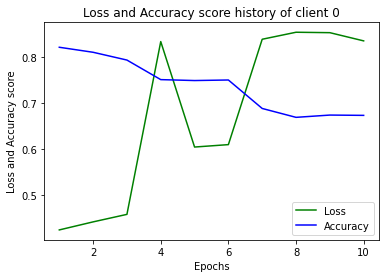

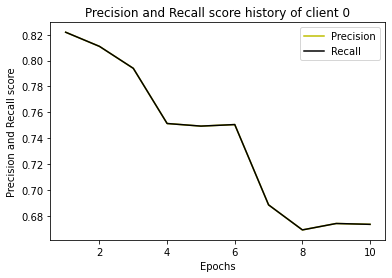

Class report of client 0
              precision    recall  f1-score   support

         0.0       0.59      0.43      0.50    149687
         1.0       0.53      0.40      0.46    104738
         2.0       0.66      0.99      0.79    104852
         4.0       0.68      0.94      0.79    104622
         6.0       0.93      0.71      0.81    104941

    accuracy                           0.67    568840
   macro avg       0.68      0.69      0.67    568840
weighted avg       0.67      0.67      0.66    568840



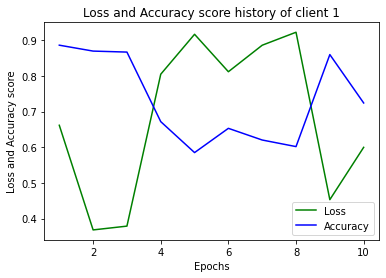

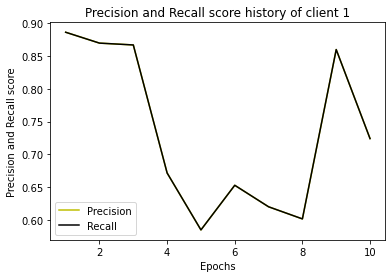

Class report of client 1
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74    185892
         1.0       0.69      0.47      0.56    130092
         2.0       0.93      0.97      0.95    130657
         3.0       0.47      1.00      0.64    129809
         4.0       0.77      0.95      0.85    129892
         5.0       0.00      0.00      0.00    130099
         6.0       0.95      0.99      0.97    130127

    accuracy                           0.72    966568
   macro avg       0.65      0.73      0.67    966568
weighted avg       0.66      0.72      0.68    966568



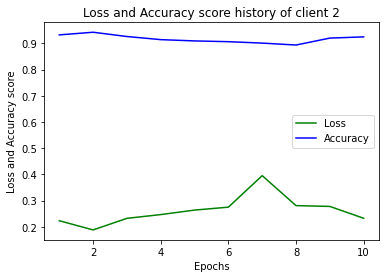

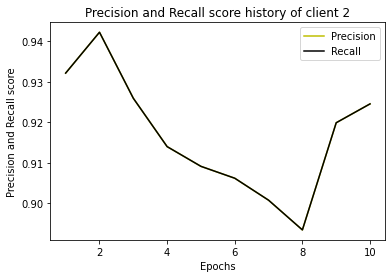

Class report of client 2
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94    122420
         1.0       0.97      0.84      0.90     85597

    accuracy                           0.92    208017
   macro avg       0.93      0.91      0.92    208017
weighted avg       0.93      0.92      0.92    208017



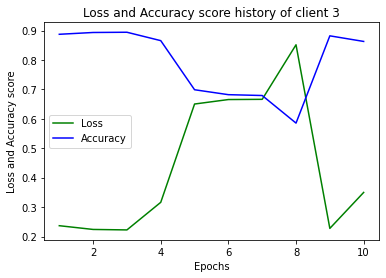

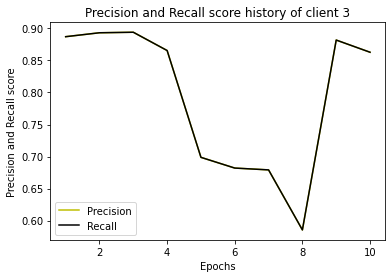

Class report of client 3
              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75     32381
         1.0       0.73      0.58      0.64     24742
         2.0       0.93      1.00      0.96     22907
         4.0       1.00      1.00      1.00     22742
         6.0       1.00      1.00      1.00     22855

    accuracy                           0.86    125627
   macro avg       0.87      0.87      0.87    125627
weighted avg       0.86      0.86      0.86    125627



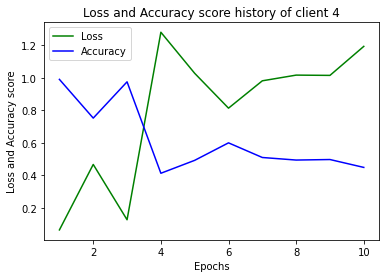

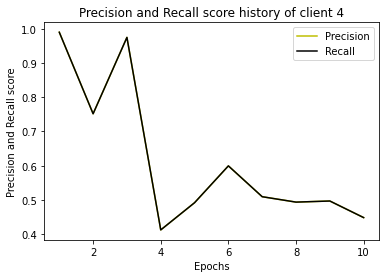

Class report of client 4
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     48371
         1.0       0.66      0.11      0.19     33870
         2.0       0.00      0.00      0.00     34158
         3.0       0.23      1.00      0.37     34318
         4.0       0.00      0.00      0.00     34192
         6.0       0.99      0.50      0.66     33998

    accuracy                           0.45    218907
   macro avg       0.48      0.42      0.36    218907
weighted avg       0.51      0.45      0.40    218907



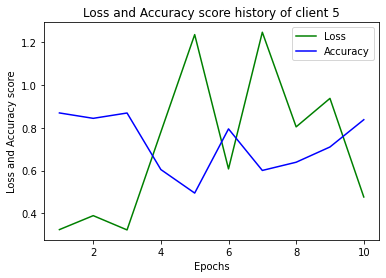

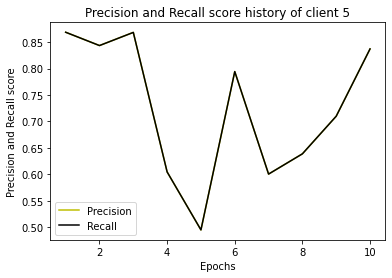

Class report of client 5
              precision    recall  f1-score   support

         0.0       0.77      0.54      0.63     22041
         1.0       0.81      0.88      0.84     29253
         3.0       0.91      1.00      0.95     20505
         6.0       0.85      0.94      0.89     20214

    accuracy                           0.84     92013
   macro avg       0.83      0.84      0.83     92013
weighted avg       0.83      0.84      0.83     92013



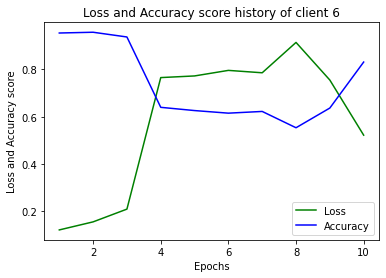

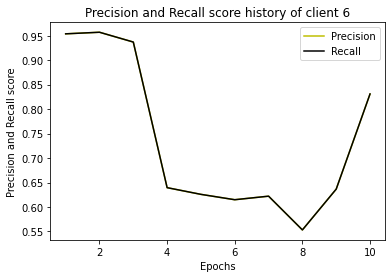

Class report of client 6
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     39274
         1.0       0.99      0.80      0.88     27275
         2.0       0.86      0.67      0.75     27368
         4.0       0.66      1.00      0.80     27638

    accuracy                           0.83    121555
   macro avg       0.85      0.83      0.83    121555
weighted avg       0.86      0.83      0.83    121555



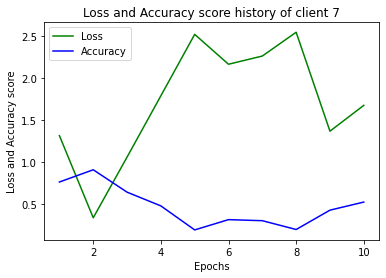

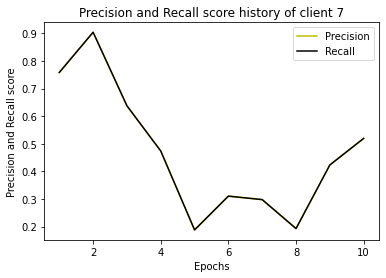

Class report of client 7
              precision    recall  f1-score   support

         0.0       0.86      0.25      0.39     14507
         1.0       0.83      0.75      0.79     19267
         2.0       0.70      0.82      0.76     13380
         3.0       0.00      0.00      0.00     13333
         4.0       0.24      0.94      0.38     13285
         5.0       0.00      0.00      0.00     13327
         6.0       0.92      0.79      0.85     13549

    accuracy                           0.52    100648
   macro avg       0.51      0.51      0.45    100648
weighted avg       0.53      0.52      0.47    100648



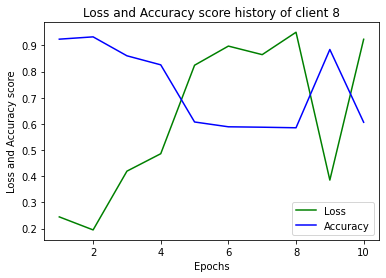

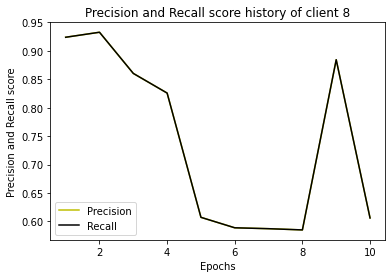

Class report of client 8
              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80     33546
         1.0       0.93      0.68      0.79     23380
         2.0       0.54      0.03      0.06     23407
         4.0       0.38      1.00      0.55     23293

    accuracy                           0.61    103626
   macro avg       0.71      0.60      0.55    103626
weighted avg       0.73      0.61      0.57    103626



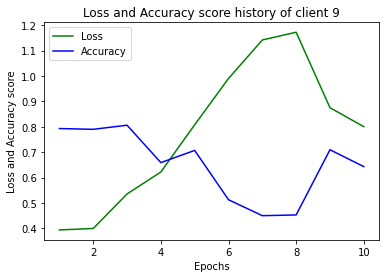

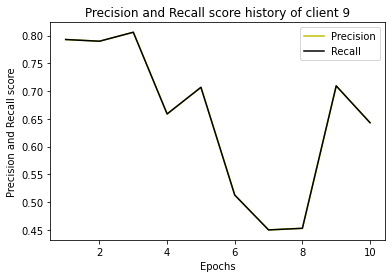

Class report of client 9
              precision    recall  f1-score   support

         0.0       0.90      0.62      0.73     25241
         1.0       0.12      0.00      0.00     17578
         2.0       0.49      0.97      0.65     17508
         3.0       0.68      1.00      0.81     17442

    accuracy                           0.64     77769
   macro avg       0.55      0.65      0.55     77769
weighted avg       0.58      0.64      0.57     77769



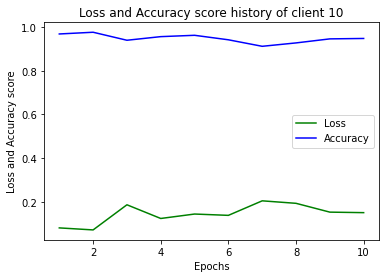

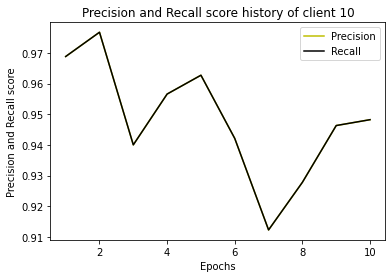

Class report of client 10
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     30477
         1.0       0.95      0.92      0.94     21344

    accuracy                           0.95     51821
   macro avg       0.95      0.94      0.95     51821
weighted avg       0.95      0.95      0.95     51821



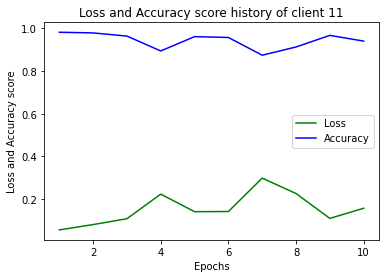

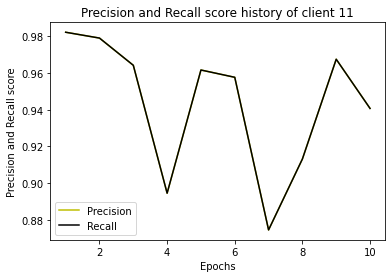

Class report of client 11
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     29283
         1.0       0.97      0.88      0.92     20431

    accuracy                           0.94     49714
   macro avg       0.95      0.93      0.94     49714
weighted avg       0.94      0.94      0.94     49714



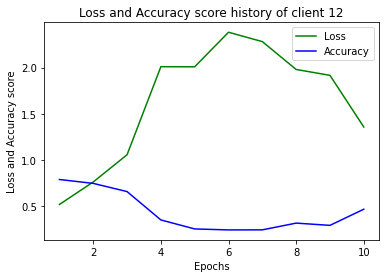

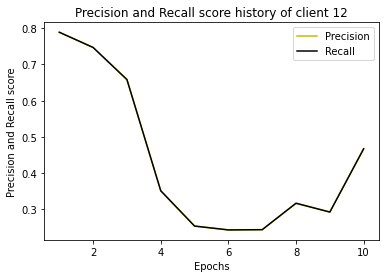

Class report of client 12
              precision    recall  f1-score   support

         0.0       0.37      0.99      0.54     15525
         1.0       0.72      0.04      0.07     11999
         2.0       0.00      0.00      0.00     10855
         6.0       0.99      0.67      0.80     10910

    accuracy                           0.47     49289
   macro avg       0.52      0.42      0.35     49289
weighted avg       0.51      0.47      0.36     49289



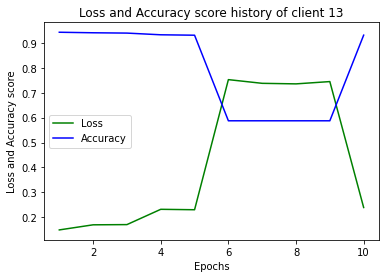

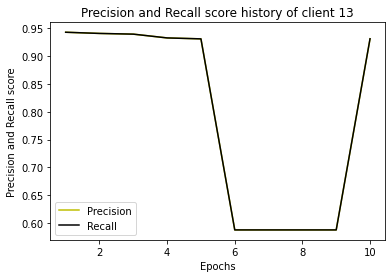

Class report of client 13
              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94     27494
         1.0       0.86      0.99      0.92     19319

    accuracy                           0.93     46813
   macro avg       0.93      0.94      0.93     46813
weighted avg       0.94      0.93      0.93     46813



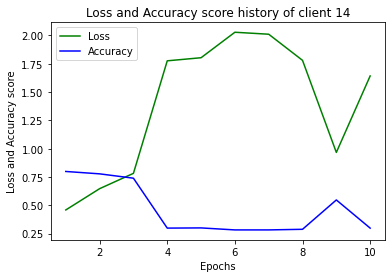

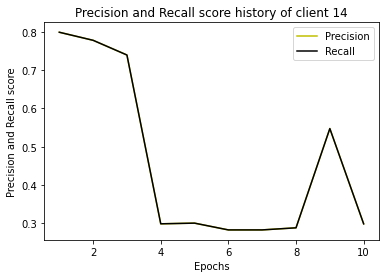

Class report of client 14
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     12805
         1.0       0.30      1.00      0.46     13524
         2.0       0.00      0.00      0.00      9548
         6.0       0.00      0.00      0.00      9432

    accuracy                           0.30     45309
   macro avg       0.07      0.25      0.11     45309
weighted avg       0.09      0.30      0.14     45309



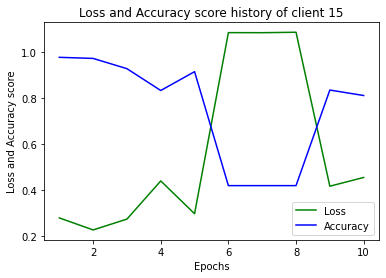

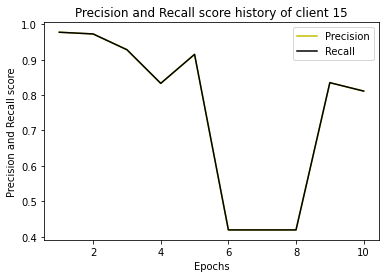

Class report of client 15
              precision    recall  f1-score   support

         0.0       0.97      0.63      0.76     24514
         1.0       0.84      0.89      0.86     16891
         2.0       0.69      1.00      0.81     17080

    accuracy                           0.81     58485
   macro avg       0.83      0.84      0.81     58485
weighted avg       0.85      0.81      0.81     58485



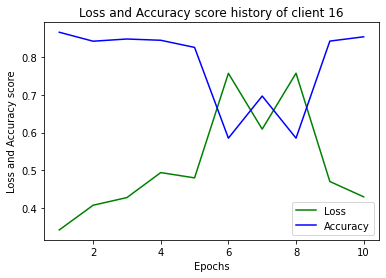

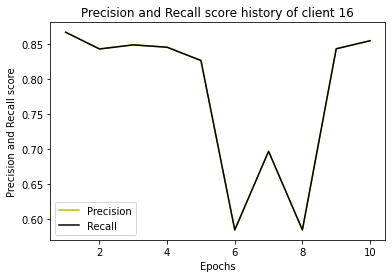

Class report of client 16
              precision    recall  f1-score   support

         0.0       0.89      0.85      0.87     22120
         1.0       0.81      0.86      0.83     15692

    accuracy                           0.85     37812
   macro avg       0.85      0.85      0.85     37812
weighted avg       0.86      0.85      0.86     37812



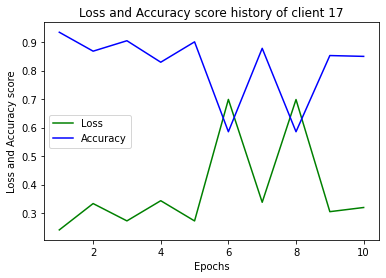

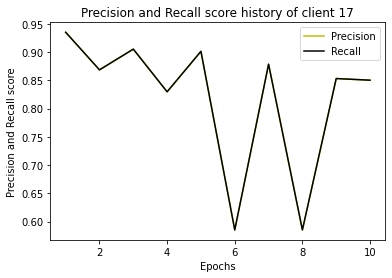

Class report of client 17
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88     23686
         1.0       0.87      0.75      0.81     16776

    accuracy                           0.85     40462
   macro avg       0.85      0.84      0.84     40462
weighted avg       0.85      0.85      0.85     40462



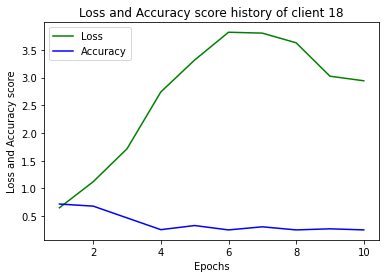

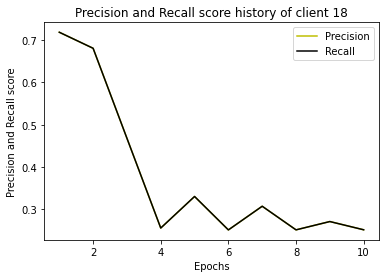

Class report of client 18
              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40      9793
         1.0       0.71      0.00      0.00     11971
         4.0       0.00      0.00      0.00      8625
         6.0       0.00      0.00      0.00      8572

    accuracy                           0.25     38961
   macro avg       0.24      0.25      0.10     38961
weighted avg       0.28      0.25      0.10     38961



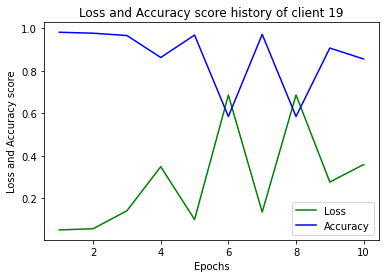

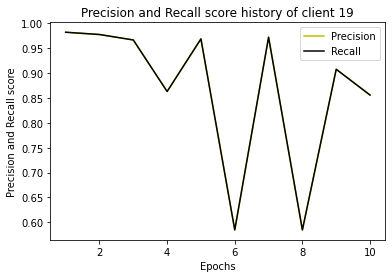

Class report of client 19
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86     20903
         1.0       0.74      1.00      0.85     14844

    accuracy                           0.86     35747
   macro avg       0.87      0.88      0.86     35747
weighted avg       0.89      0.86      0.86     35747



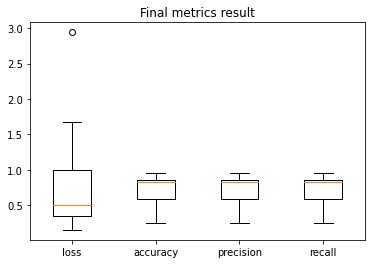

In [8]:
final_metrics = [[],[],[],[]]
for client in clients:
    client.plot_result(train_rounds)
    print(f"Class report of client {client.client_id}\n{client.report}")
    for i in range(4):
        final_metrics[i].append(client.metrics_history[-1][i])

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1,2,3,4], ['loss', 'accuracy', 'precision', 'recall'])
plt.show()